# Week5：CNN-2

## 1. 实验内容与流程

### 1.1 实验要求

 1.结合理论课内容，深入理解DenseNet、ResNeXt的结构与FaceNet的工作机制，理解Triplet loss的工作过程。

 2.简要回答实验指导书中的提出的问题。按照指导，补充或改写相应代码，使程序能够运行，并得到相应结果。

 3.提交作业时，请将实验指导书、pics文件夹和数据集文件夹一同打包提交。


### 1.2 知识预备

1.熟悉基本的分类网络，如AlexNet、VGG、ResNet，GoogleNet。

2.理解Residual Block的结构。

3.Triplet loss


### 1.3 实验内容 

1.在基础的ResNet网络结构之上，增加和修改部分结构，设计基础的DenseNet和ResNeXt网络。

2.利用Triplet loss训练一个简单的FaceNet网络，并用knn的方式进行分类预测。

3.本次实验用到的数据集是mnist的部分数据，mnist数据集包括50000张训练图片和10000张测试图片，这次选取其中2000张训练图片，每类200张，

和1000张测试图片，每类100张，作为本次实验的全部数据集。

## 2. DenseNet与ResNeXt

首先回顾一下DenseNet的结构，DenseNet的每一层都都与前面层相连，实现了特征重用。

下图表示一个DenseBlock
![DenseBlock](pics/denseblock.png)


如图所示,在一个DenseBlock中,第i层的输入不仅与i-1层的输出相关,还有所有之前层的输出有关.记作:

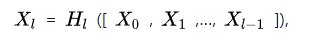

### 2.1 DenseNet网络的搭建

#### Growth_rate

   在一个DenseBlock里面，每个非线性变换H输出的channels数为恒定的Growth_rate，那么第i层的输入的channels数便是k+（i+1）* Growth_rate, k为Input
   
   的channels数，比如，假设我们把Growth_rate设为4，上图中H1的输入的size为8 * 32 * 32，输出为4 * 32 * 32， 则H2的输入的size为12 * 32 * 32，
   
   输出还是4 * 32 * 32，H3、H4以此类推，在实验中，用较小的Growth_rate就能实现较好的效果。

#### Transition Layer

请注意， 在一个DenseBlock里面，feature size并没有发生改变，因为需要对不同层的feature map进行concatenate操作，这需要保持相同的feature size。

因此在相邻的DenseBlock中间使用Down Sampling来增大感受野，即使用Transition Layer来实现，一般的Transition Layer包含BN、Conv和Avg_pool，

同时减少维度，压缩率(compress rate)通常为0.5， 即减少一半的维度。
![DenseNet](pics/densenet.png)

例如，假设block1的输出c * w * h是24 * 32 * 32，那么经过transition之后，block2的输入就是12 * 16 * 16。

#### Bottleneck

为了减少参数和计算量，DenseNet的非线性变换H采用了Bottleneck结构BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3)，1×1的卷积用于降低维度，将channels数降

低至4 * Growth_rate。

### 2.2 定义网络

In [43]:
# Load necessary modules here
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import os


class Bottleneck(nn.Module):
    '''
        the above mentioned bottleneck, including two conv layer, one's kernel size is 1×1, another's is 3×3

        after non-linear operation, concatenate the input to the output
    '''
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        
        # input and output are concatenated here
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    '''
        transition layer is used for down sampling the feature
        
        when compress rate is 0.5, out_planes is a half of in_planes
    '''
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        
        out = self.conv(F.relu(self.bn(x)))
        # use average pooling change the size of feature map here
        out = F.avg_pool2d(out, 2)
        return out 

    
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        '''
        Args:
            block: bottleneck
            nblock: a list, the elements is number of bottleneck in each denseblock
            growth_rate: channel size of bottleneck's output
            reduction: 
        '''
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)
        
        # a DenseBlock and a transition layer
        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        # the channel size is superposed, mutiply by reduction to cut it down here, the reduction is also known as compress rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes
        
        # a DenseBlock and a transition layer
        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        # the channel size is superposed, mutiply by reduction to cut it down here, the reduction is also known as compress rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        # a DenseBlock and a transition layer
        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        # the channel size is superposed, mutiply by reduction to cut it down here, the reduction is also known as compress rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        # only one DenseBlock 
        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        # the last part is a linear layer as a classifier
        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        
        # number of non-linear transformations in one DenseBlock depends on the parameter you set
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def densenet():
    return DenseNet(Bottleneck, [2, 5, 4, 6])

#### Question 1
上面的定义的DenseNet为多少层DenseNet（只计算卷积层与全连接层）？请定义一个卷积层总数为52层的DenseNet。

#### Answer 1
Every `Bottleneck` block contains 2 `Conv2d` layers; every `Transition` block contains 1 `Conv2d` layer; `_make_dense_layers` makes `nblock` `Bottleneck` blocks. We can see that the total number of `Conv2D` is 2*(2+5+4+6)/`Bottlenecks`+1*4/`Transitions` = 38. One `linear` occurs, thus the layer number is 39.

In [44]:
def densenet52():
    return  DenseNet(Bottleneck, [2, 2, 4, 16])

### 2.3 训练与测试

In [49]:
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable


def train(epoch, model, lossFunction, optimizer, device, trainloader):
    """train model using loss_fn and optimizer. When this function is called, model trains for one epoch.
    Args:
        train_loader: train data
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
        optimizer: optimize the loss function
        get_grad: True, False
    output:
        total_loss: loss
        average_grad2: average grad for hidden 2 in this epoch
        average_grad3: average grad for hidden 3 in this epoch
    """
    print('\nEpoch: %d' % epoch)
    model.train()     # enter train mode
    train_loss = 0    # accumulate every batch loss in a epoch
    correct = 0       # count when model' prediction is correct i train set
    total = 0         # total number of prediction in train set
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device) # load data to gpu device
        inputs, targets = Variable(inputs), Variable(targets)
        optimizer.zero_grad()            # clear gradients of all optimized torch.Tensors'
        outputs = model(inputs)          # forward propagation return the value of softmax function
        loss = lossFunction(outputs, targets) #compute loss
        loss.backward()                  # compute gradient of loss over parameters 
        optimizer.step()                 # update parameters with gradient descent 

        train_loss += loss.item()        # accumulate every batch loss in a epoch
        _, predicted = outputs.max(1)    # make prediction according to the outputs
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item() # count how many predictions is correct
        
        if (batch_idx+1) % 100 == 0:
            # print loss and acc
            print( 'Train loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print( 'Train loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    
def test(model, lossFunction, optimizer, device, testloader):
    """
    test model's prediction performance on loader.  
    When thid function is called, model is evaluated.
    Args:
        loader: data for evaluation
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
    output:
        total_loss
        accuracy
    """
    global best_acc
    model.eval() #enter test mode
    test_loss = 0 # accumulate every batch loss in a epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = lossFunction(outputs, targets) #compute loss

            test_loss += loss.item() # accumulate every batch loss in a epoch
            _, predicted = outputs.max(1) # make prediction according to the outputs
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item() # count how many predictions is correct
        # print loss and acc
        print('Test Loss: %.3f  | Test Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

        
def data_loader():
    # define method of preprocessing data for evaluating
    transform_train = transforms.Compose([
        transforms.Resize(32),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Normalize a tensor image with mean and standard variance
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        # Normalize a tensor image with mean and standard variance
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    # prepare dataset by ImageFolder, data should be classified by directory
    trainset = torchvision.datasets.ImageFolder(root='./mnist/train', transform=transform_train)

    testset = torchvision.datasets.ImageFolder(root='./mnist/test', transform=transform_test)

    # Data loader. 

    # Combines a dataset and a sampler, 

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)
    return trainloader, testloader

def run(model, num_epochs):
    
    # load model into GPU device
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = 'cuda:1' 
    model.to(device)
    if device == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True

    # define the loss function and optimizer

    lossFunction = nn.CrossEntropyLoss()
    lr = 0.01
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    trainloader, testloader = data_loader()
    for epoch in range(num_epochs):
        train(epoch, model, lossFunction, optimizer, device, trainloader)
        test(model, lossFunction, optimizer, device, testloader)
        if (epoch + 1) % 50 == 0 :
            lr = lr / 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

用你自己定义的DenseNet进行测试

In [22]:
# start training and testing
model = densenet52()
# num_epochs is adjustable
run(model, num_epochs=20)


Epoch: 0
Train loss: 2.238 | Train Acc: 18.300% (366/2000)
Test Loss: 2.308  | Test Acc: 10.000% (100/1000)

Epoch: 1
Train loss: 1.825 | Train Acc: 39.500% (790/2000)
Test Loss: 1.612  | Test Acc: 36.100% (361/1000)

Epoch: 2
Train loss: 1.333 | Train Acc: 58.400% (1168/2000)
Test Loss: 1.724  | Test Acc: 46.900% (469/1000)

Epoch: 3
Train loss: 0.908 | Train Acc: 71.500% (1430/2000)
Test Loss: 0.779  | Test Acc: 75.100% (751/1000)

Epoch: 4
Train loss: 0.667 | Train Acc: 79.250% (1585/2000)
Test Loss: 0.878  | Test Acc: 71.700% (717/1000)

Epoch: 5
Train loss: 0.596 | Train Acc: 78.500% (1570/2000)
Test Loss: 0.765  | Test Acc: 70.000% (700/1000)

Epoch: 6
Train loss: 0.496 | Train Acc: 82.500% (1650/2000)
Test Loss: 0.550  | Test Acc: 78.000% (780/1000)

Epoch: 7
Train loss: 0.444 | Train Acc: 85.250% (1705/2000)
Test Loss: 0.697  | Test Acc: 73.200% (732/1000)

Epoch: 8
Train loss: 0.450 | Train Acc: 85.600% (1712/2000)
Test Loss: 0.574  | Test Acc: 78.000% (780/1000)

Epoch: 9
Tr

### 2.4 ResNeXt网络的搭建

###### cardinality

cardinality, 指的是repeat layer的个数，下图右边cardinality为32。左图是ResNet的基本结构，输入channel size为64，右图是ResNeXt的基本结构，

输入channel size是128，但两者具有相近的参数量。
![cardinality](pics/cardinality.png)

###### ResNeXt Block

有三种等价的ResNeXt Block，如下图，a是ResNeXt基本单元，如果把输出那里的1x1合并到一起，得到等价网络b拥有和Inception-ResNet相似的结构，

而进一步把输入的1x1也合并到一起，得到等价网络c则和通道分组卷积的网络有相似的结构。
![ResNeXtBlock](pics/ResNeXtBlock.png)

###### ResNeXt网络结构

下图表示ResNeXt-50(32x4d)的网络结构，卷积层和全连接层总数为50层，32表示的是cardinality,4d表示每一个repeat layer的channel数为4，所以整个block的通道数是32x4=128.
![ResNeXt](pics/ResNeXt.png)

In [50]:
class Block(nn.Module):
    '''
        Grouped convolution block(c).
        
    '''
    expansion = 2

    def __init__(self, in_planes, cardinality=32, bottleneck_width=4, stride=1):
        '''
            in_planes: channel size of input
            cardinality: number of groups
            bottleneck_width: channel size of each group
        '''
        super(Block, self).__init__()
        group_width = cardinality * bottleneck_width
        self.conv1 = nn.Conv2d(in_planes, group_width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(group_width)
        # divide into 32 groups which 32 is cardinality
        self.conv2 = nn.Conv2d(group_width, group_width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(group_width)
        self.conv3 = nn.Conv2d(group_width, self.expansion*group_width, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*group_width)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*group_width:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*group_width, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*group_width)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [51]:
class ResNeXt(nn.Module):
    def __init__(self, num_blocks, cardinality, bottleneck_width, num_classes=10):
        '''
            num_blocks: list type, channel size of input
            cardinality: number of groups
            bottleneck_width: channel size of each group
        '''
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # size 32x32
        self.layer1 = self._make_layer(num_blocks[0], 1)
        # size 32x32
        self.layer2 = self._make_layer(num_blocks[1], 2)
        # size 16x16
        self.layer3 = self._make_layer(num_blocks[2], 2)
        # size 8x8
        self.linear = nn.Linear(cardinality*bottleneck_width*8, num_classes)

    def _make_layer(self, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_planes, self.cardinality, self.bottleneck_width, stride))
            self.in_planes = Block.expansion * self.cardinality * self.bottleneck_width
        # Increase bottleneck_width by 2 after each stage.
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


#### Question 2
定义一个ResNeXt-32(16x8d)（补全下面一行代码），仿照DenseNet的方式训练和测试这个网络得出前20个epoch结果，分析这个结果好或坏的原因

In [52]:
ResNeXt32_16x8d = ResNeXt([3, 3, 3], 16, 8)
run(ResNeXt32_16x8d, num_epochs=20)


Epoch: 0
Train loss: 2.167 | Train Acc: 17.650% (353/2000)
Test Loss: 4.626  | Test Acc: 10.000% (100/1000)

Epoch: 1
Train loss: 1.719 | Train Acc: 37.950% (759/2000)
Test Loss: 1.829  | Test Acc: 36.000% (360/1000)

Epoch: 2
Train loss: 1.139 | Train Acc: 59.450% (1189/2000)
Test Loss: 1.462  | Test Acc: 47.800% (478/1000)

Epoch: 3
Train loss: 0.768 | Train Acc: 73.500% (1470/2000)
Test Loss: 1.732  | Test Acc: 57.800% (578/1000)

Epoch: 4
Train loss: 0.602 | Train Acc: 78.850% (1577/2000)
Test Loss: 1.518  | Test Acc: 60.900% (609/1000)

Epoch: 5
Train loss: 0.522 | Train Acc: 83.050% (1661/2000)
Test Loss: 1.213  | Test Acc: 67.700% (677/1000)

Epoch: 6
Train loss: 0.369 | Train Acc: 88.500% (1770/2000)
Test Loss: 0.349  | Test Acc: 90.400% (904/1000)

Epoch: 7
Train loss: 0.312 | Train Acc: 90.150% (1803/2000)
Test Loss: 0.369  | Test Acc: 89.300% (893/1000)

Epoch: 8
Train loss: 0.272 | Train Acc: 92.050% (1841/2000)
Test Loss: 0.476  | Test Acc: 85.800% (858/1000)

Epoch: 9
Tr

#### Answer 2

ResNet and DenseNet are proved to have the same path topology – “dense topology” essentially, whilst their only difference lies in the form of connections. 

However, there is some differences in this experiment. Clearly see that generalization error of the two NNs are approximately the same, and empirical error of ResNext is lower. 

DenseNet has some shortcomings:

- In general case, DenseNet uses a lot more memory, as the tensors from different are concatenated together compared with ResNeXt. [Ref. 1](https://medium.com/@smallfishbigsea/densenet-2b0889854a92)
- Although Densenet can reuse the feature, dense connection ($L(L − 1)2$) increases its computating time. [Ref. 2](https://www.imooc.com/article/36508) The excessive connections not only decrease networks' computation-efficiency and parameter-efficiency, but also make networks more prone to overfitting. [Ref. 3](https://arxiv.org/pdf/1804.05340.pdf)

In this situation, ResNeXt enjoys more merits:

- ResNeXt derives the shorcut thinking of ResNet, who add multi-branch Inception as enhancement. Thus, ResNeXt inherits the strong modularity and high scalability of its predecessor - ResNet. [Ref. 4](https://arxiv.org/pdf/1611.05431.pdf) [Ref. 5](https://imlogm.github.io/%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0/resnet/)

## 3.FaceNet

有关FaceNet与triplet loss的理论知识请同学们复习理论课有关章节。在这里，我们将用triplet loss训练一个resnet18网络，并用这个网络在mnist数据集上进行KNN分类，具体的，resnet18相当于一个特征提取器，用所有的训练集图片的特征拟合一个KNN分类器，利用这个KNN分类进行预测. 在3.1小节，将给出triplet loss的实现. 3.2小节将实现一个适用于triplet loss训练的resnet18网络. 3.3小节将实现随机选取triplet的dataset, 3.4、3.5小节将分别实现resnet18的训练与测试函数.

###### embedding size

FaceNet 的作用是将图像嵌入一个d维的空间，在这个d维空间里，同一类图像的特征之间相隔的近，不同类图像的特征之间相隔的远，这个d我们称之为embedding size

### 3.1 triplet loss

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import os
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable,Function

class PairwiseDistance(Function):
    '''
        compute distance of the embedding features, p is norm, when p is 2, then return L2-norm distance
    '''
    def __init__(self, p):
        super(PairwiseDistance, self).__init__()
        self.norm = p

    def forward(self, x1, x2):
        eps = 1e-6  # in case of zeros
        diff = torch.abs(x1 - x2)     # subtraction
        out = torch.pow(diff, self.norm).sum(dim=1) # square
        return torch.pow(out + eps, 1. / self.norm) # L-p norm


class TripletLoss(Function):
    '''
       Triplet loss function.
       loss = max(diatance(a,p) - distance(a,n) + margin, 0)
       forward method:
           args:
                anchor, positive, negative
           return:
                triplet loss
    '''
    def __init__(self, margin, num_classes=10):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.num_classes = num_classes
        self.pdist = PairwiseDistance(2) # to calculate distance

    def forward(self, anchor, positive, negative):
        d_p = self.pdist.forward(anchor, positive) # distance of anchor and positive
        d_n = self.pdist.forward(anchor, negative) # distance of anchor and negative
        
        dist_hinge = torch.clamp(self.margin + d_p - d_n, min=0.0) # ensure loss is no less than zero
        loss = torch.mean(dist_hinge)
        return loss


### 3.2 resnet-18 for triplet loss

In [54]:
class BasicBlock(nn.Module):
    '''
        resnet basic block.
        one block includes two conv layer and one residual
    '''
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):

        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

    
class ResNetTriplet(nn.Module):
    def __init__(self, block, num_blocks, embedding_size=256, num_classes=10):
        super(ResNetTriplet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # feature map size 32x32
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        # feature map size 32x32
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        # feature map size 16x16
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # feature map size 8x8
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # feature map size 4x4
        # as we use resnet basic block, the expansion is 1
        self.linear = nn.Linear(512*block.expansion, embedding_size)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def l2_norm(self,input):
        input_size = input.size()
        buffer = torch.pow(input, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)
        _output = torch.div(input, norm.view(-1, 1).expand_as(input))
        output = _output.view(input_size)
        return output

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        # normalize the features, then we set margin easily
        self.features = self.l2_norm(out)
        # multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        alpha = 10
        self.features = self.features * alpha
        # here we get the 256-d features, next we use those features to make prediction
        return self.features

    
def ResNet18(embedding_size=256, num_classes=10):
    
    return ResNetTriplet(BasicBlock, [2,2,2,2], embedding_size, num_classes)


### 3.3 triplet dataloader

#### Question 3
仔细阅读下面代码，对pic_classes的作用进行思考，回答下面问题：下面选取triplet的方式是随机选取，若要改为选择指定类别选取，怎么修改？请写出修改后的两行代码。

#### Answer

`Pic_classes` is convenient for us to find the path of the image id in `train.csv` and `test.csv`. For example, the corresponding content of `pic_classes['0']` is a list of ids of image with a number of 0.

In order to produce a triplet sample, we need to take two pictures from the category of pos_class (one anc and one pos) and one picture from neg_class.

``` python
# you need to assign value to selected_pos(neg)_class first
pos_class = selected_pos_class
neg_class = selected_neg_class
```

[Ref. 1](https://www.jianshu.com/p/46c6f68264a1) [Ref. 2](https://www.jianshu.com/p/b1188c9f5fd2)

In [55]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset


class TripletFaceDataset(Dataset):

    def __init__(self, root_dir, csv_name, num_triplets, transform = None):
        '''
        randomly select triplet,which means anchor,positive and negative are all selected randomly.
        args:
            root_dir : dir of data set
            csv_name : dir of train.csv
            num_triplets: total number of triplets
        '''
        
        self.root_dir          = root_dir
        self.df                = pd.read_csv(csv_name)
        self.num_triplets      = num_triplets
        self.transform         = transform
        self.training_triplets = self.generate_triplets(self.df, self.num_triplets)
        
    @staticmethod
    def generate_triplets(df, num_triplets):
        
        def make_dictionary_for_pic_class(df):

            '''
                make csv to the format that we want
              - pic_classes = {'class0': [class0_id0, ...], 'class1': [class1_id0, ...], ...}
            '''
            pic_classes = dict()
            for idx, label in enumerate(df['class']):
                if label not in pic_classes:
                    pic_classes[label] = []
                pic_classes[label].append(df.iloc[idx, 0])
            return pic_classes
        
        triplets    = []
        classes     = df['class'].unique()
        pic_classes = make_dictionary_for_pic_class(df)
        
        for _ in range(num_triplets):

            '''
              - randomly choose anchor, positive and negative images for triplet loss
              - anchor and positive images in pos_class
              - negative image in neg_class
              - at least, two images needed for anchor and positive images in pos_class
              - negative image should have different class as anchor and positive images by definition
            '''
        
            pos_class = np.random.choice(classes)     # random choose positive class
            neg_class = np.random.choice(classes)     # random choose negative class
            
            # if choose anchor
            while len(pic_classes[pos_class]) < 2:
                pos_class = np.random.choice(classes)
            # if neg in the same class as anchor and pos
            while pos_class == neg_class:
                neg_class = np.random.choice(classes)

            pos_name = df.loc[df['class'] == pos_class, 'name'].values[0] # get positive class's name
            neg_name = df.loc[df['class'] == neg_class, 'name'].values[0] # get negative class's name

            if len(pic_classes[pos_class]) == 2:
                ianc, ipos = np.random.choice(2, size = 2, replace = False)
            else:
                # both anchor and positive images are in pos_class but are not the same image
                ianc = np.random.randint(0, len(pic_classes[pos_class]))  # random choose anchor
                ipos = np.random.randint(0, len(pic_classes[pos_class]))  # random choose positive
                while ianc == ipos:
                    ipos = np.random.randint(0, len(pic_classes[pos_class]))
            ineg = np.random.randint(0, len(pic_classes[neg_class]))      # random choose negative

            triplets.append([pic_classes[pos_class][ianc], pic_classes[pos_class][ipos], pic_classes[neg_class][ineg],
                 pos_class, neg_class, pos_name, neg_name])
        
        return triplets
    
    
    def __getitem__(self, idx):
        
        anc_id, pos_id, neg_id, pos_class, neg_class, pos_name, neg_name = self.training_triplets[idx]
        
        anc_img   = os.path.join(self.root_dir, str(pos_name), str(anc_id) + '.png') # join the path of anchor
        pos_img   = os.path.join(self.root_dir, str(pos_name), str(pos_id) + '.png') # join the path of positive
        neg_img   = os.path.join(self.root_dir, str(neg_name), str(neg_id) + '.png') # join the path of nagetive
        
        anc_img = Image.open(anc_img).convert('RGB') # open the anchor image
        pos_img = Image.open(pos_img).convert('RGB') # open the positive image
        neg_img = Image.open(neg_img).convert('RGB') # open the negative image

        pos_class = torch.from_numpy(np.array([pos_class]).astype('long'))  # make label transform the type we want
        neg_class = torch.from_numpy(np.array([neg_class]).astype('long'))  # make label transform the type we want

        data = [anc_img, pos_img,neg_img]
        label = [pos_class, pos_class, neg_class]

        if self.transform:
            data = [self.transform(img)  # preprocessing the image
                    for img in data]
            
        return data, label
    
    def __len__(self):
        
        return len(self.training_triplets)



### 3.4 train function for triplet loss

In [56]:
import torchvision.transforms as transforms

def train_facenet(epoch, model, optimizer, margin, num_triplets):
    model.train()
    # preprocessing function for image
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=np.array([0.4914, 0.4822, 0.4465]),
            std=np.array([0.2023, 0.1994, 0.2010])),
    ])
    
    # get dataset of triplet
    
    # num_triplet is adjustable
    train_set = TripletFaceDataset(root_dir     = './mnist/train',
                                   csv_name     = './mnist/train.csv',
                                   num_triplets = num_triplets,
                                   transform    = transform)

    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size  = 16,
                                               shuffle     = True)

    total_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        # load data to gpu
        data[0], target[0] = data[0].cuda(device='cuda:1'), target[0].cuda(device='cuda:1')  # anchor to cuda
        data[1], target[1] = data[1].cuda(device='cuda:1'), target[1].cuda(device='cuda:1')  # positive to cuda
        data[2], target[2] = data[2].cuda(device='cuda:1'), target[2].cuda(device='cuda:1')  # negative to cuda

        data[0], target[0] = Variable(data[0]), Variable(target[0]) # anchor
        data[1], target[1] = Variable(data[1]), Variable(target[1]) # positive
        data[2], target[2] = Variable(data[2]), Variable(target[2]) # negative
        # zero setting the grad
        optimizer.zero_grad()
        # forward
        anchor   = model.forward(data[0])
        positive = model.forward(data[1])
        negative = model.forward(data[2])
        
        # margin is adjustable
        loss = TripletLoss(margin=margin, num_classes=10).forward(anchor, positive, negative) # get triplet loss
        total_loss += loss.item()
        # back-propagating
        loss.backward()
        optimizer.step()

    context = 'Train Epoch: {} [{}/{}], Average loss: {:.4f}'.format(
        epoch, len(train_loader.dataset), len(train_loader.dataset), total_loss / len(train_loader))
    print(context)

### 3.5 test function for triplet loss

关于如何测试的问题，由于triplet loss训练的resnet18网络没有分类器，这个网络的最后一层的输出是一个维度为embedding_size的向量，我们把它当作由模型提取出的特征，所以利用这个特征来做测试。首先保存下训练集上所有图片的特征和标签，用sklearn库的KNeighborsClassifier()拟合成一个KNN分类器，这里的K表示领域的个数，K是一个可调节的参数，在测试集上做验证时，提取图片的特征用KNN分类器做预测即可。

#### Question 4
仔细阅读下面代码，回答问题：下面的预测方法为KNN预测，若要改为中心点预测的方式，即找出每个类别的离均值点最近的图片做最近邻预测，请简述找出中心点的方法，无需写代码。

#### Answer 4

1. First, the model is used to output the one-hot vectors of each type of image - **cluster**. 
2. Then, the mean value - **center** - of each cluster is calculated. 
3. Images who are relatively closer to the center in the cluster are found as the representatives. 
4. In the prediction, the similarity between the image and the centers is calculated.
5. Finally, we obtain the classification result.

In [71]:
from sklearn import neighbors
import pandas
import matplotlib.pyplot as plt
        
def KNN_classifier(model, epoch, n_neighbors):
    '''
        use all train set data to make KNN classifier
    '''
    model.eval()
    # preprocessing function for image
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=np.array([0.485, 0.456, 0.406]),
            std=np.array([0.229, 0.224, 0.225])),
    ])
    # prepare dataset by ImageFolder, data should be classified by directory
    train_set = torchvision.datasets.ImageFolder(root='./mnist/train', transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)

    features, labels =[], [] # store features and labels
    for i, (data, target) in enumerate(train_loader):
        #  load data to gpu
        data, target = data.cuda(device='cuda:1'), target.cuda(device='cuda:1')
        data, target = Variable(data), Variable(target)
        # forward
        output = model(data)
        # get features and labels to make knn classifier
        features.extend(output.data.cpu().numpy())
        labels.extend(target.data.cpu().numpy())
        
    # n_neighbor is adjustable
    clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(features, labels)

    return clf


def find_nearest_image(feature, label, model, clf):
    
    model.eval()
    
    # preprocessing function for image
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=np.array([0.485, 0.456, 0.406]),
            std=np.array([0.229, 0.224, 0.225])),
    ])
    
    frame = pandas.read_csv('./mnist/train.csv')
    
    # prepare dataset by ImageFolder, data should be classified by directory
    train_set = torchvision.datasets.ImageFolder(root = './mnist/train', transform = transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = False)
    
    features = []
    targets = []
    
    for i, (data, target) in enumerate(train_loader):
        # load data to gpu
        data, target = data.cuda(device='cuda:1'), target.cuda(device='cuda:1')
        data, target = Variable(data), Variable(target)
        
        # forward
        output = model.forward(data)
        
        features.extend(output.data.cpu().numpy())
        targets.extend(target.data.cpu().numpy())
        
    min_index = -1
    min_dist = 0
    for index in range(len(features)):
        if targets[index] == label:
            dist = np.linalg.norm(feature - features[index])
            if min_index == -1:
                min_dist = dist
                min_index = 0
            else:
                if dist < min_dist:
                    min_dist = dist
                    min_index = index
    
    return os.path.join('./mnist/train/', str(frame['name'][min_index]), str(frame['id'][min_index]) + '.png')
    

def test_facenet(epoch, model, clf, test = True, last = False):
    model.eval()
    # preprocessing function for image
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=np.array([0.485, 0.456, 0.406]),
            std=np.array([0.229, 0.224, 0.225])),
    ])
    
    frame = pandas.read_csv('./mnist/test.csv')
    
    # prepare dataset by ImageFolder, data should be classified by directory
    test_set = torchvision.datasets.ImageFolder(root = './mnist/test' if test else './mnist/train', transform = transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = False)

    correct, total = 0, 0
    features = []
    predicts = []
    targets = []
    
    for i, (data, target) in enumerate(test_loader):
        # load data to gpu
        data, target = data.cuda(device='cuda:1'), target.cuda(device='cuda:1')
        data, target = Variable(data), Variable(target)
        
        # forward
        output = model.forward(data)
        # predict by knn classifier
        predicted = clf.predict(output.data.cpu().numpy())
        
        correct += (torch.tensor(predicted) == target.data.cpu()).sum()
        total += target.size(0)
        
        if test and last:
            features.extend(output.data.cpu().numpy())
            targets.extend(target.data.cpu().numpy())
            predicts.extend(torch.tensor(predicted).numpy())
            
    if test and last:
        err_count = 0
        for index in range(len(features)):
            if not predicts[index] == targets[index]:
                image_path = os.path.join('./mnist/test/', str(frame['name'][index]), str(frame['id'][index]) + '.png')
                image = Image.open(image_path).convert('RGB')
                
                plt.subplot(1,3,1)
                plt.imshow(image)
                
                # save origin images
                error_image_path = os.path.join('./pics/errors/', 'img%d_origin_(%d).png' %(err_count, targets[index]))
                image.save(error_image_path)
                
                path_nearest_target = find_nearest_image(features[index], targets[index], model, clf)
                path_nearest_predict = find_nearest_image(features[index], predicts[index], model, clf)
                
                image_nearest_target = Image.open(path_nearest_target).convert('RGB')
                image_nearest_predict = Image.open(path_nearest_predict).convert('RGB')
                
                plt.subplot(1,3,2)
                plt.imshow(image_nearest_target)
                
                plt.subplot(1,3,3)
                plt.imshow(image_nearest_predict)
                plt.show()
                
                # save nearest taget
                target_image_path = os.path.join('./pics/errors/', 'img%d_near_tgt_(%d).png' %(err_count, targets[index]))
                image_nearest_target.save(target_image_path)
                
                # save nearest predict
                predict_image_path = os.path.join('./pics/errors/', 'img%d_near_pdc_(%d).png' %(err_count, predicts[index]))
                image_nearest_predict.save(predict_image_path)
                
                err_count += 1
                
        print("Error images saved!")
    
    
    context = 'Accuracy of model in ' + ('test' if test else 'train') + \
              ' set is {}/{}({:.2f}%)'.format(correct, total, 100. * float(correct) / float(total))
    print(context)


### 3.6训练与测试

In [72]:
def run_facenet():
    # hyper parameter
    lr = 0.008
    margin = 2.0
    num_triplets = 8000
    n_neighbors = 5
    embedding_size = 128
    num_epochs = 5
    
    # embedding_size is adjustable
    model = ResNet18(embedding_size, 10)
    
    # load model into GPU device
    device = torch.device('cuda:1')
    model = model.to(device)
    if device == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    
    # define the optimizer, lr、momentum、weight_decay is adjustable
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    
    print('start training')
    for epoch in range(num_epochs):  
        train_facenet(epoch, model, optimizer, margin, num_triplets) # train resnet18 with triplet loss
        clf = KNN_classifier(model, epoch, n_neighbors)     # get knn classifier
        last = False
        if epoch == num_epochs - 1:
            last = True
        test_facenet(epoch, model, clf, False)  # validate train set
        test_facenet(epoch, model, clf, True, last)   # validate test set
        if (epoch + 1) % 4 == 0 :
            lr = lr / 3
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        

start training
Train Epoch: 0 [8000/8000], Average loss: 0.3779
Accuracy of model in train set is 1899/2000(94.95%)
Accuracy of model in test set is 939/1000(93.90%)
Train Epoch: 1 [8000/8000], Average loss: 0.0987
Accuracy of model in train set is 1967/2000(98.35%)
Accuracy of model in test set is 960/1000(96.00%)
Train Epoch: 2 [8000/8000], Average loss: 0.0527
Accuracy of model in train set is 1970/2000(98.50%)
Accuracy of model in test set is 971/1000(97.10%)
Train Epoch: 3 [8000/8000], Average loss: 0.0376
Accuracy of model in train set is 1983/2000(99.15%)
Accuracy of model in test set is 985/1000(98.50%)
Train Epoch: 4 [8000/8000], Average loss: 0.0165
Accuracy of model in train set is 1994/2000(99.70%)


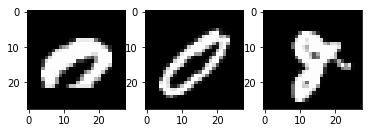

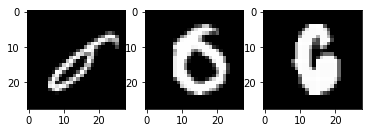

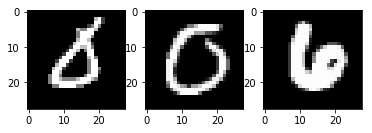

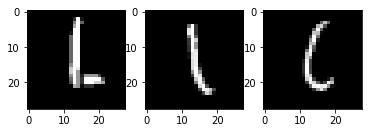

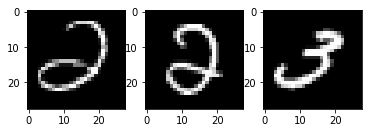

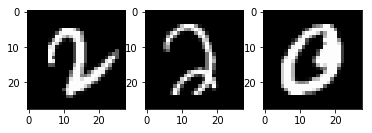

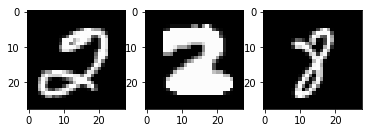

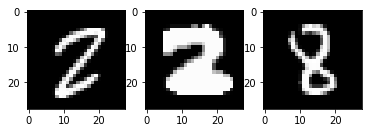

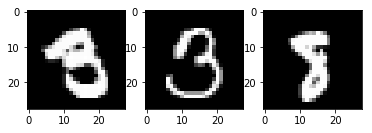

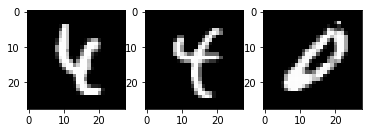

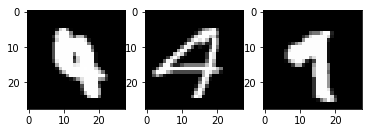

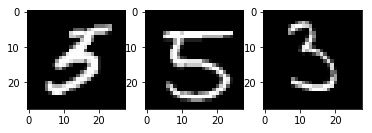

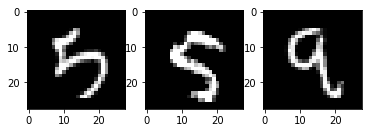

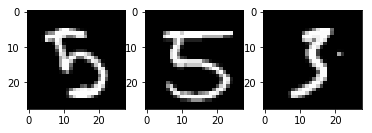

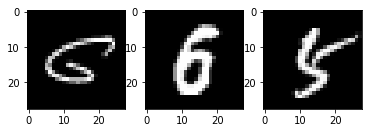

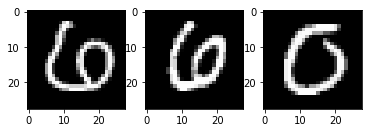

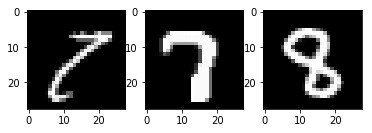

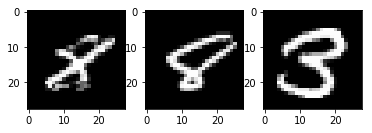

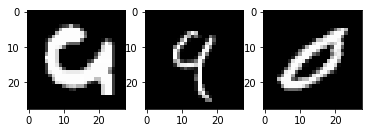

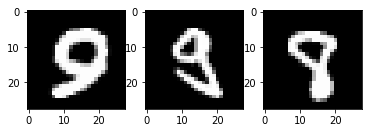

Error images saved!
Accuracy of model in test set is 980/1000(98.00%)


In [73]:
run_facenet()

#### Question 5

训练一个较好的resnet18网络，收集在测试集上所有预测错误的样本图片（1000张测试集图片，分错不应超过30张，5%）。并在训练集上找出离这个样本最近的同类样本和错类样本的图片，**并作出简要分析**（15%）。例如，对于一个样本sample，正确类别为A，模型将其错分为B，分别找出训练集中A类样本和B类样本中离sample最近的样本图片（注意是图片！**注意一定要保存在pics文件夹或者自定义文件夹一同提交，否则TA看不到，将图片在下面展示出来**）。

###### hints：重写 test_facenet()函数

###### hints：根据特征反向寻找图片可参考下列代码. 需保证shuffle=False，train.csv和test.csv均已给出

#### Answer 5

To collect the errors among the test set, a director named `./pics/errors` serves to save the wrong predictions. `test_facenet()` is rewritten as above. Errors are saved in format like `img + err_count +origin(near_tgt, near_pdc) + (res)`. 

From the results, we can find that most specimen errors occurs when the scripts are too blurry or the digits are too similar. And confusions between **0 and 6, 2 and 3, 3 and 8, 5 and 3 ...** are common.

### 3.7 Hard triplet

Triplet loss的性能与采样方式有很大的关系，这里简述两种hard-triplet的采样方式，batch-hard与semi-hard。

#### Batch hard

对于每一个minibatch，随机选择P个类，每一类随机挑选K张不同的图片，即一个minibatch有PxK张不同的图片。每一张图片都作为anchor，找出minibatch里面距离anchor最远的正样本和距离最近的负样本，组成一个triplet。loss可表示为：
![batch_hard](pics/batch_hard.png)

#### Semi hard

与batch-hard不同，semi-hard triplet只需要保证minibatch中anchor到positive的距离小于anchor到negative的距离即为semi-hard，见下图，不需要选出minibatch里面距离anchor最远的负样本
![semi_hard](pics/semi_hard.png)

#### Question 6
本次实验是分类任务的最后一次实验，你对分类任务的学习有何感想？

#### Answer 6

- It's really any onerous work for only a tiny lift!!!
- Sometimes, GPU overcome the computing problem, but this also blind us to some extent. We usually do not attach high importance to the computing difficulties. (~~Bad for algorithm innovation???~~)
- The recognition of performances of such complicated NNs are hard to finally verdict, for we lack support from other cases.
- Some intriguing ticks such as triplet and BCE are introduced in the modules, inspires us and motivating us to eplore further at the meantime.
- ResNet and DenseNet are really siblings, they come from one family! And it's interesting to see their deviations.
- *From my own perspective, the progression after ResNet is not showing a lot of progress somehow (probably because of the limitation of dataset), so the advancement is still murky for me.*
- I really admire the intelligence of the people who come up with the similarity comparing and loss caculating methods, that's really amazing.

## 作业附加题：
pytorch实现batch-hard或semi-hard的其中一种，重新训练resnet18，对比上面的随机选择triplet的采样方法，其训练过程和结果有何不同，你有更优的方法吗？（不做不扣分，实现一种有较高加分，鼓励同学们挑战高难度）